# NHL Forward Clustering

This file is used to cluster NHL forwards into different tiers.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Forward Clustering

In [2]:
# Load Forwards
nhl_forwards = pd.read_csv('../dataset/preprocess/nhl_forwards.csv')

In [3]:
nhl_forwards

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description,age_by_2025
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...,56
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...,52
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...,49
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...,45
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,3869.0,Dean Sylvester,3,2,96.0,1.0,52.0,21.0,16.0,37.0,...,USA,188,91,R,NaN,NaN,NaN,[],"Brothers: Evan Sylvester, Todd Sylvester",52
1600,3870.0,Mike Sullivan,11,11,709.0,19.0,81.0,54.0,82.0,136.0,...,USA,188,84,L,NaN,NaN,"('4', '69', '1987')",[],Son: Matt Sullivan\r\nSon-in-law: Charlie McAvoy,57
1601,3880.0,Jean-Pierre Vigier,6,5,213.0,2.0,72.0,23.0,23.0,46.0,...,Canada,182,86,R,NaN,NaN,NaN,"['1-time AHL Calder Cup Champion', '1-time AHL...","Cousins: Ian Vigier, Stephan Vigier",49
1602,3897.0,Viktor Tikhonov,2,2,111.0,11.0,61.0,11.0,11.0,22.0,...,Russia,187,87,R,NaN,NaN,"('1', '28', '2008')","['1-time World Championship Gold Medal', '1-ti...",Tikhonov is a forward with fine offensive abil...,37


## Processing Stats Attributes (numeric)

- Select numeric columns

- Standardize them

In [4]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
stats_cols = [
    "gp_regular_total", "gp_regular_min_per_season", "gp_regular_max_per_season",
    "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean", "toi_per_game_regular_mean",
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    "gp_playoffs_sum", "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean", "toi_per_game_playoffs_mean",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game"
]

# Fill missing values with 0
nhl_forwards[stats_cols] = nhl_forwards[stats_cols].fillna(0)

# Standardize the data
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(nhl_forwards[stats_cols])

## Categorical Encoding

- `nation`, `shoots`, `player_pos_official`, `player_type` -> One-hot encoding

- `draft`

    - Convert to structured features: round, overall, year

- `highlights`, `description` -> Textual features (not used in clustering)

In [5]:
# Handle Nation and Shoots by One-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot_cols = ["nation", "shoots", "player_pos_official"]
ohe = OneHotEncoder(handle_unknown='ignore')
X_onehot = ohe.fit_transform(nhl_forwards[onehot_cols])

In [6]:
# Handle Player Type
import ast

# Step 1: Ensure player_type column is always a list
def parse_types(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # safely evaluate string representation of list
        except (ValueError, SyntaxError):
            return [x.strip()] if x.strip() else []
    return []

nhl_forwards['player_type'] = nhl_forwards['player_type'].apply(parse_types)

# Step 2: Get all unique player types
all_types = sorted(set(pt for types in nhl_forwards['player_type'] for pt in types))

# Step 3: One-hot encode player types
for pt in all_types:
    col_name = f"player_type_{pt.replace(' ', '_').lower()}"
    nhl_forwards[col_name] = nhl_forwards['player_type'].apply(lambda x: int(pt in x))

# Step 4: Select the one-hot encoded columns
X_player_type = nhl_forwards[[col for col in nhl_forwards.columns if col.startswith("player_type_")]]

In [7]:
# Handle Draft
nhl_forwards['draft_round'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[0]) if pd.notnull(x) else None)
nhl_forwards['draft_overall'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[1]) if pd.notnull(x) else None)
nhl_forwards['draft_year'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[2]) if pd.notnull(x) else None)


In [8]:
# Extract Draft Features into X_draft
draft_cols = ['draft_round', 'draft_overall', 'draft_year']
X_draft = nhl_forwards[draft_cols]

In [9]:
nhl_forwards

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,player_type_puckhandler,player_type_role_player,player_type_sniper,player_type_speedster,player_type_two-way_center,player_type_two-way_forward,player_type_workhorse,draft_round,draft_overall,draft_year
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,0,0,0,0,0,0,0,1.0,15.0,1987.0
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,0,0,0,0,1,0,0,1.0,6.0,1991.0
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,0,1,0,0,0,0,4.0,87.0,1994.0
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,0,0,0,0,0,0,0,1.0,12.0,1998.0
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,0,0,0,0,0,0,0,3.0,72.0,1994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,3869.0,Dean Sylvester,3,2,96.0,1.0,52.0,21.0,16.0,37.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1600,3870.0,Mike Sullivan,11,11,709.0,19.0,81.0,54.0,82.0,136.0,...,0,0,0,0,0,0,0,4.0,69.0,1987.0
1601,3880.0,Jean-Pierre Vigier,6,5,213.0,2.0,72.0,23.0,23.0,46.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1602,3897.0,Viktor Tikhonov,2,2,111.0,11.0,61.0,11.0,11.0,22.0,...,0,0,0,0,0,0,0,1.0,28.0,2008.0


### Handle Highlights

1. Normalize the highlights columns

2. Extract Award Features

3. Aggregate to General Award Metrics

In [10]:
import ast
import re
import pandas as pd

# Load your Excel file
df_awards = pd.read_csv("../dataset/nhl_players_metadata_facts_merged_final.csv")

# Convert stringified lists into actual lists
df_awards["highlights"] = df_awards["highlights"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all highlights into a single list
all_highlights = [item for sublist in df_awards["highlights"] for item in sublist]

# Regex pattern: matches "1-time " or "2-time " etc. at the start
pattern = re.compile(r"^\d+-time\s+")

# Extract NHL related awards
all_highlights = [h for h in all_highlights if "NHL" in h]

# Normalize award names
normalized_awards = [pattern.sub("", h).strip() for h in all_highlights]

# Extract unique award names
unique_awards = sorted(set(normalized_awards))

# Show them
for award in unique_awards:
    print(award)

NHL 4 Nations Champion
NHL 4 Nations MVP
NHL 4 Nations Most Points
NHL All-Rookie Team
NHL Best Defenseman (Norris Trophy)
NHL Contribution to U.S. Hockey (Lester Patrick Trophy)
NHL First All-Star Team
NHL Foundation Player Award
NHL Gentleman Conduct (Lady Byng Trophy)
NHL Leadership-Humanitarian Award (King Clancy Trophy)
NHL MVP Selected by NHLPA (Ted Lindsay Award)
NHL Mark Messier Leadership Award
NHL Most Assists
NHL Most Goals (Maurice Richard Trophy)
NHL Most Points (Art Ross Trophy)
NHL Most Valuable Player (Hart Trophy)
NHL Rookie of the Year (Calder Trophy)
NHL Second All-Star Team
NHL Sportsmanship Award (Bill Masterton Trophy)
NHL Stanley Cup Champion
NHL Stanley Cup MVP (Conn Smythe Trophy)
NHL Top Defensive Forward (Frank J. Selke Trophy)


In [11]:
import re

# Define NHL-related awards
# Define NHL-related awards keywords from all_highlights
award_keywords = {
    "4nations_champion": "NHL 4 Nations Champion",
    "4nations_mvp": "NHL 4 Nations MVP",
    "4nations_points": "NHL 4 Nations Most Points",
    "all_rookie": "NHL All-Rookie Team",
    "norris": "NHL Best Defenseman (Norris Trophy)",
    "patrick": "NHL Contribution to U.S. Hockey (Lester Patrick Trophy)",
    "all_star_first": "NHL First All-Star Team",
    "foundation": "NHL Foundation Player Award",
    "lady_byng": "NHL Gentleman Conduct (Lady Byng Trophy)",
    "king_clancy": "NHL Leadership-Humanitarian Award (King Clancy Trophy)",
    "ted_lindsay": "NHL MVP Selected by NHLPA (Ted Lindsay Award)",
    "messier": "NHL Mark Messier Leadership Award",
    "most_assists": "NHL Most Assists",
    "richard": "NHL Most Goals (Maurice Richard Trophy)",
    "art_ross": "NHL Most Points (Art Ross Trophy)",
    "hart": "NHL Most Valuable Player (Hart Trophy)",
    "calder": "NHL Rookie of the Year (Calder Trophy)",
    "all_star_second": "NHL Second All-Star Team",
    "masterton": "NHL Sportsmanship Award (Bill Masterton Trophy)",
    "stanley_cup": "NHL Stanley Cup Champion",
    "conn_smythe": "NHL Stanley Cup MVP (Conn Smythe Trophy)",
    "selke": "NHL Top Defensive Forward (Frank J. Selke Trophy)",
    "hhof": "Hockey Hall of Fame"
}


def extract_awards(awards_list):
    """Count NHL-related awards for a player."""
    award_counts = {key: 0 for key in award_keywords.keys()}

    if pd.isna(awards_list):
        return award_counts

    # Convert stringified list to list if necessary
    if isinstance(awards_list, str):
        try:
            awards_list = eval(awards_list)
        except:
            awards_list = [awards_list]

    for award in awards_list:
        text = str(award).lower()
        for key, phrase in award_keywords.items():
            if phrase.lower() in text:
                # Check for counts like "5-time" or "2-time"
                match = re.search(r"(\d+)[- ]?time", text)
                count = int(match.group(1)) if match else 1
                award_counts[key] += count

    return award_counts

# Apply the function to the highlights column
award_features = nhl_forwards['highlights'].apply(extract_awards).apply(pd.Series)

# Merge the award counts back into the main dataframe
nhl_forwards = pd.concat([nhl_forwards, award_features], axis=1)

# Fill NaNs with 0 for awards
nhl_forwards[award_features.columns] = nhl_forwards[award_features.columns].fillna(0)

# Show the first 5 players
nhl_forwards.head()

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,richard,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,0,0,1,0,0,0,2,1,0,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,0,1,1,1,0,0,2,0,0,1
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,1,0,0,0,1,0,1,0,0,0
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,0,0,0,1,0,0,1,0,0,1


In [12]:
# Extract Award Features into X_highlights
award_cols = award_features.columns

X_highlights = nhl_forwards[award_cols]

## Combine All Features

In [13]:
from scipy.sparse import hstack

# Combine all features
X_combined = hstack([X_stats_scaled, X_onehot, X_player_type, X_draft, X_highlights]).toarray()

## Dimensionality Reduction

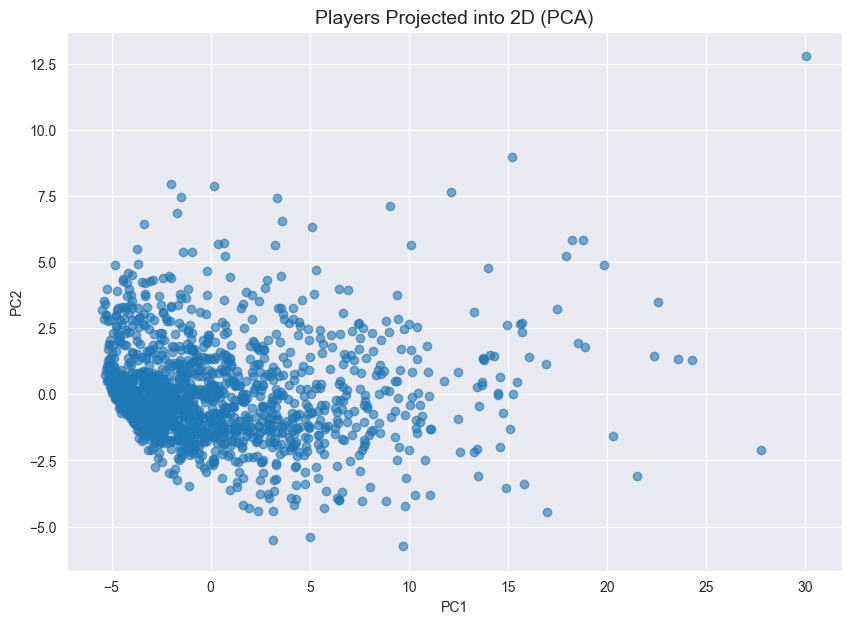

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (PCA)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


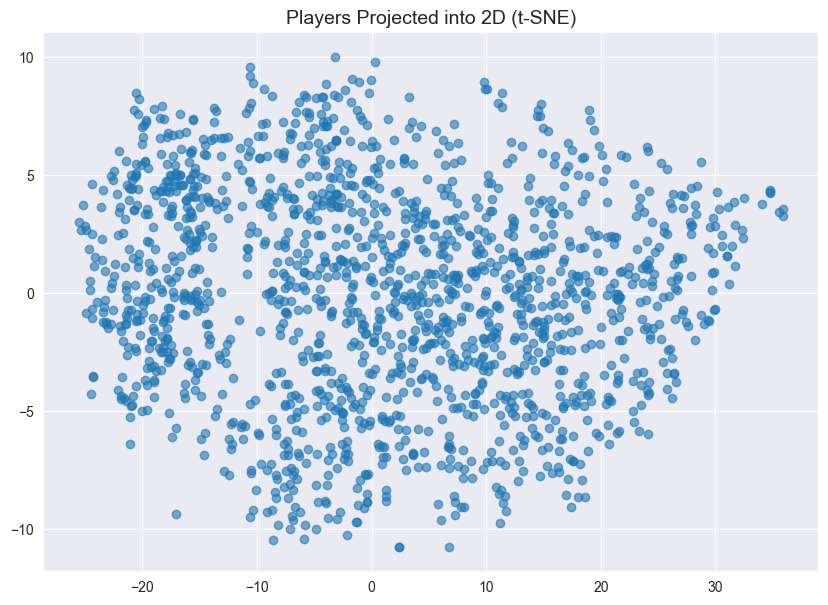

In [15]:
from sklearn.manifold import TSNE

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

X_tsne = TSNE(n_components=3, perplexity=30, random_state=42).fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (t-SNE)", fontsize=14)
plt.show()

## Clustering

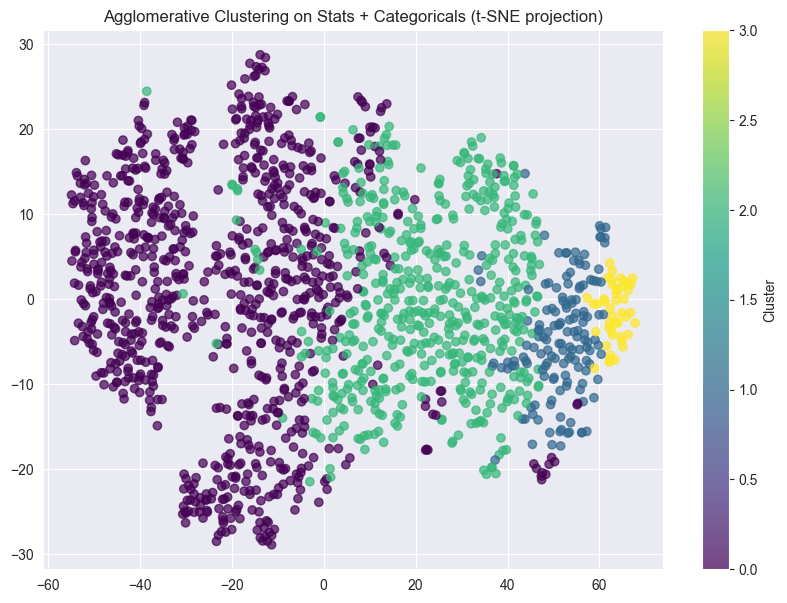

In [16]:
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

# Step 2: Cluster in high-dimensional space
agg = AgglomerativeClustering(n_clusters=4)
labels = agg.fit_predict(X_dense)

# Add cluster labels back to DataFrame
nhl_forwards['cluster'] = labels

# Step 3: Project to 2D with t-SNE for visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_dense)

# Step 4: Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (t-SNE projection)")
plt.show()

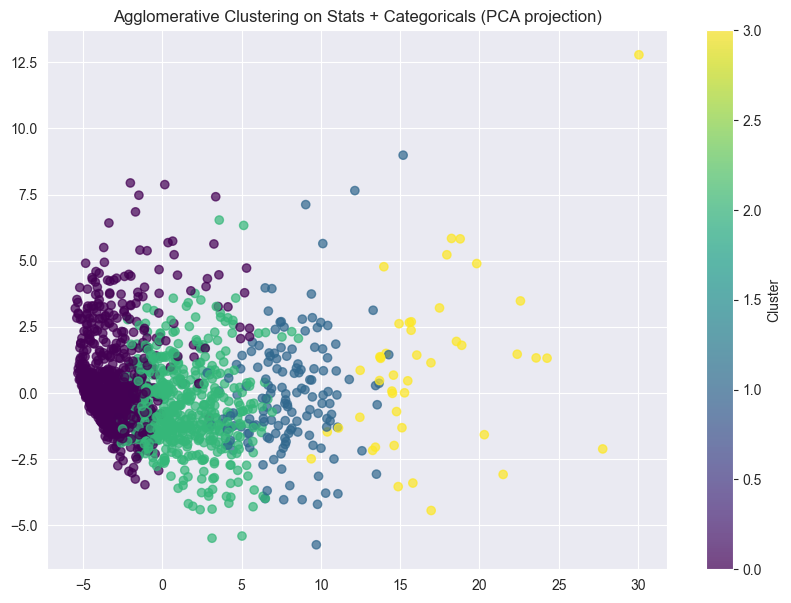

In [17]:
# Plot the clustering result using PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (PCA projection)")
plt.show()

In [18]:
# Show the average p_regular_per_season for each cluster
nhl_forwards.groupby('cluster')['p_regular_per_season'].mean()

cluster
0    12.359749
1    49.998733
2    31.096478
3    70.046777
Name: p_regular_per_season, dtype: float64

In [19]:
# Assign cluster labels to tiers
nhl_forwards['tier'] = nhl_forwards['cluster'].map({
    3: 1, # Tier 1
    1: 2, # Tier 2
    2: 3, # Tier 3
    0: 4  # Tier 4
})

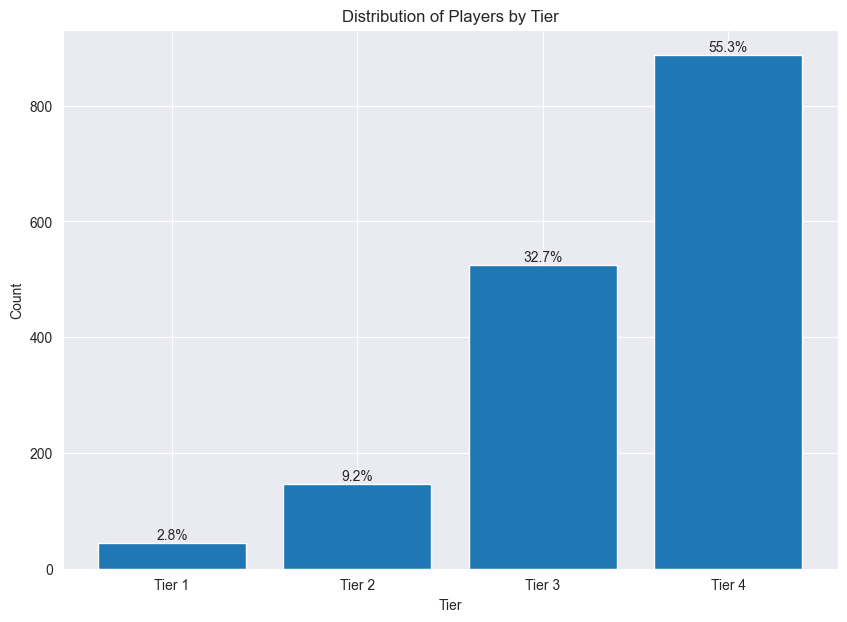

In [20]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_forwards['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_forwards) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [21]:
# Find Sidney Crosby's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Sidney Crosby']['tier'].values[0]

np.int64(1)

In [22]:
# Find Jarome Iginla's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Jarome Iginla']['tier'].values[0]

np.int64(2)

In [23]:
# Show the count of each tier
nhl_forwards['tier'].value_counts()

tier
4    887
3    525
2    147
1     45
Name: count, dtype: int64

## Further Clustering Tier 2 Forwards

Tier 2 Forwards count: 147
Feature dimensions: (147, 150)


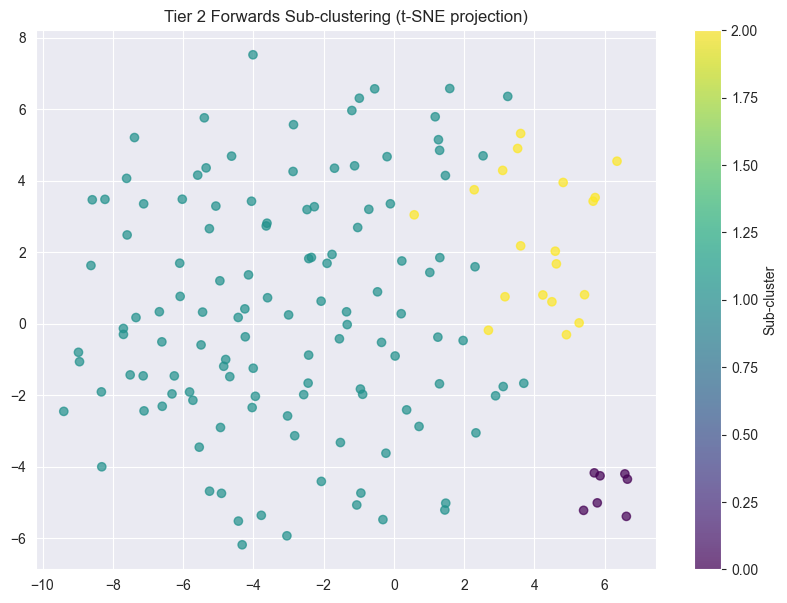

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get tier 2 forwards indices
tier_2_indices = nhl_forwards[nhl_forwards['tier'] == 2].index

# Extract the corresponding features
X_tier_2 = X_dense[tier_2_indices]

print(f"Tier 2 Forwards count: {len(tier_2_indices)}")
print(f"Feature dimensions: {X_tier_2.shape}")

# Perform sub-clustering into 3 groups
agg_tier2 = AgglomerativeClustering(n_clusters=3)
tier_2_labels = agg_tier2.fit_predict(X_tier_2)

# Create sub-tiers (1a, 1b, 1c)
tier_2_forwards = nhl_forwards.loc[tier_1_indices].copy()
# Map cluster labels to sub-tier names
label_map = {0: '2a', 1: '2b', 2: '2c'}
tier_2_forwards['sub_tier'] = pd.Series(tier_2_labels, index=tier_2_forwards.index).map(label_map)


# Visualize the sub-clustering with t-SNE
X_tier_2_tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=min(30, len(tier_2_indices)//3)
).fit_transform(X_tier_2)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier_2_tsne[:, 0], X_tier_2_tsne[:, 1], c=tier_2_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 2 Forwards Sub-clustering (t-SNE projection)")
plt.show()


In [26]:
# Show the average p_regular_per_season for each cluster
tier_2_forwards.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
2a    64.517382
2b    49.869658
2c    45.471755
Name: p_regular_per_season, dtype: float64

In [27]:
# Show the count of each sub-tier
tier_2_forwards['sub_tier'].value_counts()

sub_tier
2b    121
2c     19
2a      7
Name: count, dtype: int64

In [28]:
# Show Iginla's sub-tier
tier_2_forwards[tier_2_forwards['player_name_official'] == 'Jarome Iginla']['sub_tier'].values[0]

'2b'

In [29]:
# Show Auston Matthew's Tier
tier_2_forwards[tier_2_forwards['player_name_official'] == 'Auston Matthews']['sub_tier'].values[0]

'2b'

In [30]:
# Show 2a players
tier_2_forwards[tier_2_forwards['sub_tier'] == '2b']

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,cluster,tier,sub_tier
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,1,0,1,0,0,0,1,2,2b
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,0,0,0,1,0,0,0,1,2,2b
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,1,0,0,1,0,0,1,1,2,2b
6,8.0,Adam Deadmarsh,9,9,567.0,18.0,78.0,184.0,189.0,373.0,...,0,0,0,1,0,0,0,1,2,2b
38,75.0,Andrew Brunette,16,16,1110.0,11.0,82.0,268.0,465.0,733.0,...,0,0,0,0,0,0,0,1,2,2b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,3679.0,Mike Ricci,16,16,1099.0,6.0,83.0,243.0,362.0,605.0,...,0,0,0,1,0,0,0,1,2,2b
1551,3699.0,Logan Couture,15,14,933.0,6.0,82.0,323.0,378.0,701.0,...,0,0,0,0,0,0,0,1,2,2b
1559,3751.0,Kirk Muller,19,19,1349.0,10.0,82.0,357.0,602.0,959.0,...,0,0,0,1,0,0,0,1,2,2b
1565,3767.0,Jamie Benn,16,16,1192.0,41.0,82.0,399.0,557.0,956.0,...,0,1,0,0,0,0,0,1,2,2b


Tier 2b Forwards count: 121
Feature dimensions: (121, 150)


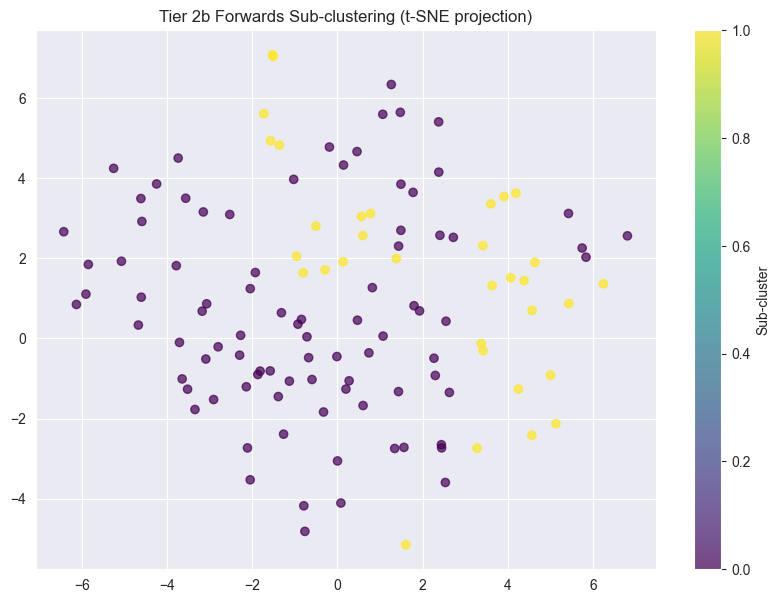

In [31]:
# Further Clustering Tier 2b Forwards
tier_2b_indices = tier_2_forwards[tier_2_forwards['sub_tier'] == '2b'].index
X_tier_2b = X_dense[tier_2b_indices]
print(f"Tier 2b Forwards count: {len(tier_2b_indices)}")
print(f"Feature dimensions: {X_tier_2b.shape}")

# Perform sub-clustering into 2 groups
agg_tier2b = AgglomerativeClustering(n_clusters=2)
tier2b_labels = agg_tier2b.fit_predict(X_tier_2b)

# Create sub-tiers (2ba, 2bb)
label_map = {0: '2ba', 1: '2bb'}
tier_2_forwards.loc[tier_2b_indices, 'sub_tier'] = pd.Series(tier2b_labels, index=tier_2b_indices).map(label_map)

# Visualize the sub-clustering with t-SNE
X_tier2b_tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=min(30, len(tier_2b_indices)//3)
).fit_transform(X_tier_2b)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier2b_tsne[:, 0], X_tier2b_tsne[:, 1], c=tier2b_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 2b Forwards Sub-clustering (t-SNE projection)")
plt.show()

In [32]:
# Show the average p_regular_per_season for each cluster
tier_2_forwards.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
2a     64.517382
2ba    45.871732
2bb    60.530797
2c     45.471755
Name: p_regular_per_season, dtype: float64

In [33]:
# Show the count of each sub-tier
tier_2_forwards['sub_tier'].value_counts()

sub_tier
2ba    88
2bb    33
2c     19
2a      7
Name: count, dtype: int64

In [34]:
# Show the players in 2bb
tier_2_forwards[tier_2_forwards['sub_tier'] == '2bb']

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,cluster,tier,sub_tier
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,1,0,1,0,0,0,1,2,2bb
39,76.0,Pierre Turgeon,19,19,1294.0,8.0,83.0,515.0,812.0,1327.0,...,0,0,0,0,0,0,1,1,2,2bb
65,120.0,Ryan O'Reilly,16,16,1152.0,13.0,82.0,303.0,521.0,824.0,...,0,0,0,1,1,1,0,1,2,2bb
87,173.0,Jarome Iginla,20,20,1554.0,13.0,82.0,625.0,675.0,1300.0,...,0,1,0,0,0,0,1,1,2,2bb
146,293.0,Zach Parise,19,19,1254.0,13.0,82.0,434.0,455.0,889.0,...,0,1,0,0,0,0,0,1,2,2bb
158,318.0,Tony Amonte,15,15,1174.0,7.0,83.0,416.0,484.0,900.0,...,0,0,0,0,0,0,1,1,2,2bb
202,414.0,Peter Bondra,16,16,1081.0,23.0,83.0,503.0,389.0,892.0,...,0,0,0,0,0,0,0,1,2,2bb
255,509.0,Artemi Panarin,10,10,752.0,42.0,82.0,302.0,568.0,870.0,...,1,2,0,0,0,0,0,1,2,2bb
339,673.0,Rick Nash,15,15,1060.0,11.0,82.0,437.0,368.0,805.0,...,0,0,0,0,0,0,0,1,2,2bb
385,778.0,Marian Gaborik,17,17,1035.0,12.0,82.0,407.0,408.0,815.0,...,0,1,0,1,0,0,0,1,2,2bb


In [35]:
# Combine tier 2a and 2b into tier 1
nhl_forwards.loc[tier_2_forwards[tier_2_forwards['sub_tier'] == '2a'].index, 'tier'] = 1

# Change tier 2b to tier 1
nhl_forwards.loc[tier_2_forwards[tier_2_forwards['sub_tier'] == '2bb'].index, 'tier'] = 1

# Remove sub_tier
tier_2_forwards.drop(['sub_tier'], axis=1, inplace=True)

In [36]:
# Show the count of each tier
nhl_forwards['tier'].value_counts()

tier
4    887
3    525
2    107
1     85
Name: count, dtype: int64

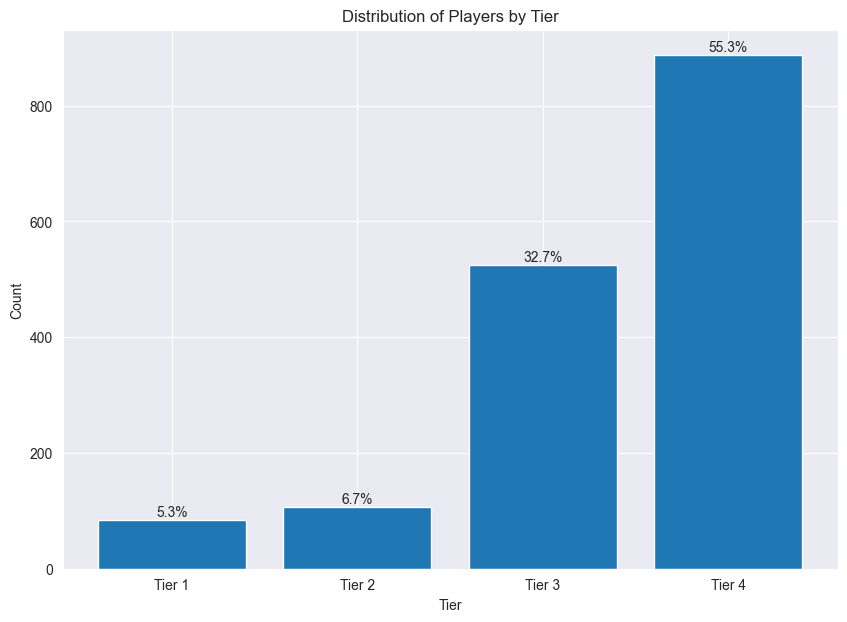

In [37]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_forwards['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_forwards) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [38]:
# Find Sidney Crosby's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Sidney Crosby']['tier'].values[0]

np.int64(1)

In [39]:
# Find Jarome Iginla's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Jarome Iginla']['tier'].values[0]

np.int64(1)

In [40]:
# Find Auston Matthews' Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Auston Matthews']['tier'].values[0]

np.int64(1)

In [41]:
# Show Tier 1 Forwards
nhl_forwards[nhl_forwards['tier'] == 1]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,cluster,tier
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,1,0,0,0,2,1,0,1,3,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,1,1,0,0,2,0,0,1,3,1
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,0,1,0,1,0,0,0,1,1
28,56.0,Paul Kariya,15,15,989.0,11.0,82.0,402.0,587.0,989.0,...,0,0,2,0,0,0,0,1,1,1
29,58.0,Teemu Selanne,21,21,1451.0,12.0,84.0,684.0,773.0,1457.0,...,0,1,2,1,1,0,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,3521.0,Henrik Zetterberg,15,15,1082.0,45.0,82.0,337.0,623.0,960.0,...,0,0,1,0,1,1,0,0,3,1
1497,3532.0,Mike Modano,21,21,1499.0,30.0,82.0,561.0,813.0,1374.0,...,0,0,1,0,1,0,0,2,3,1
1501,3539.0,Daniel Alfredsson,18,18,1246.0,47.0,82.0,444.0,713.0,1157.0,...,0,1,1,0,0,0,0,1,3,1
1548,3691.0,Joe Pavelski,18,18,1332.0,46.0,82.0,476.0,592.0,1068.0,...,0,0,1,0,0,0,0,0,3,1


## Further Clustering Tier 3 Forwards and Tier 4 Forwards

In [42]:
# Further Clustering Tier 3 and 4 Forwards
tier_3_indices = nhl_forwards[nhl_forwards['tier'] == 3].index
tier_4_indices = nhl_forwards[nhl_forwards['tier'] == 4].index

X_tier_3 = X_dense[tier_3_indices]
X_tier_4 = X_dense[tier_4_indices]

print(f"Tier 3 Forwards count: {len(tier_3_indices)}")
print(f"Feature dimensions: {X_tier_3.shape}")
print(f"Tier 4 Forwards count: {len(tier_4_indices)}")
print(f"Feature dimensions: {X_tier_4.shape}")

# Perform sub-clustering into 2 groups for tier 3
agg_tier3 = AgglomerativeClustering(n_clusters=2)
tier3_labels = agg_tier3.fit_predict(X_tier_3)

# Create sub-tiers (3a, 3b)
tier_3_forwards = nhl_forwards.loc[tier_3_indices].copy()
label_map = {0: '3a', 1: '3b'}
tier_3_forwards['sub_tier'] = pd.Series(tier3_labels, index=tier_3_forwards.index).map(label_map)

# Perform sub-clustering into 2 groups for tier 4
agg_tier4 = AgglomerativeClustering(n_clusters=2)
tier4_labels = agg_tier4.fit_predict(X_tier_4)

# Create sub-tiers (4a, 4b)
tier_4_forwards = nhl_forwards.loc[tier_4_indices].copy()
label_map = {0: '4a', 1: '4b'}
tier_4_forwards['sub_tier'] = pd.Series(tier4_labels, index=tier_4_forwards.index).map(label_map)

Tier 3 Forwards count: 525
Feature dimensions: (525, 150)
Tier 4 Forwards count: 887
Feature dimensions: (887, 150)


### Visualize the sub-clustering with t-SNE

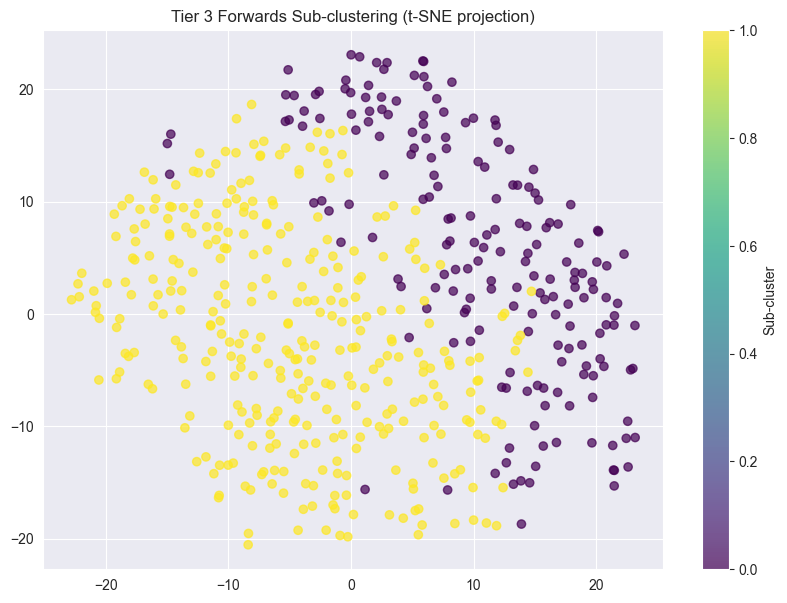

In [43]:
# Visualize the sub-clustering with t-SNE for tier 3
X_tier3_tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=min(30, len(tier_3_indices)//3)
).fit_transform(X_tier_3)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier3_tsne[:, 0], X_tier3_tsne[:, 1], c=tier3_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 3 Forwards Sub-clustering (t-SNE projection)")
plt.show()

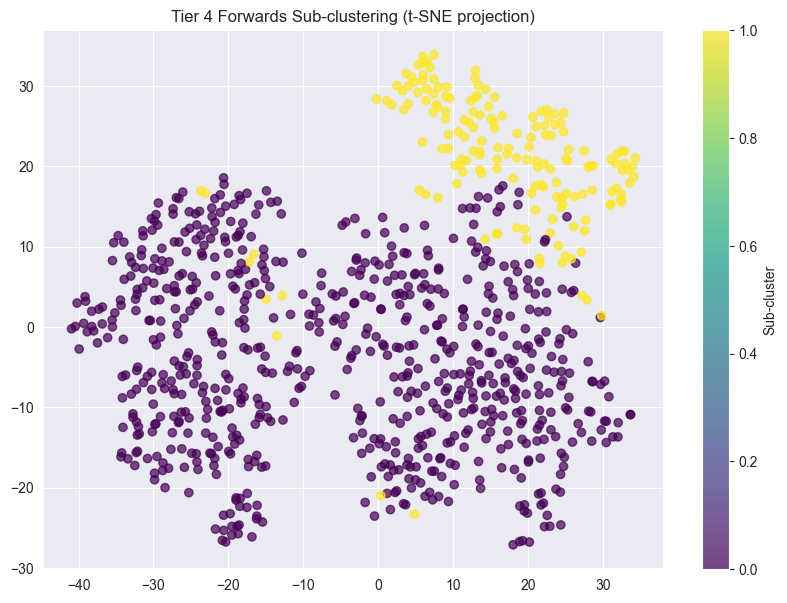

In [44]:
# Visualize the sub-clustering with t-SNE for tier 4
X_tier4_tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=min(30, len(tier_4_indices)//3)
).fit_transform(X_tier_4)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier4_tsne[:, 0], X_tier4_tsne[:, 1], c=tier4_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 4 Forwards Sub-clustering (t-SNE projection)")
plt.show()

In [45]:
# Show the average p_regular_per_season for each cluster
tier_3_forwards.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
3a    37.897834
3b    27.302251
Name: p_regular_per_season, dtype: float64

In [46]:
# Show the average p_regular_per_season for each cluster
tier_4_forwards.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
4a    12.494787
4b    11.790209
Name: p_regular_per_season, dtype: float64

In [47]:
# Show the count of each sub-tier
tier_3_forwards['sub_tier'].value_counts()

sub_tier
3b    337
3a    188
Name: count, dtype: int64

In [48]:
# Show the count of each sub-tier
tier_4_forwards['sub_tier'].value_counts()

sub_tier
4a    717
4b    170
Name: count, dtype: int64

In [49]:
# Change 3a to tier 2
nhl_forwards.loc[tier_3_forwards[tier_3_forwards['sub_tier'] == '3a'].index, 'tier'] = 2

# Change 4b to tier 3
nhl_forwards.loc[tier_4_forwards[tier_4_forwards['sub_tier'] == '4b'].index, 'tier'] = 3

# Drop sub_tier
tier_3_forwards.drop(['sub_tier'], axis=1, inplace=True)
tier_4_forwards.drop(['sub_tier'], axis=1, inplace=True)

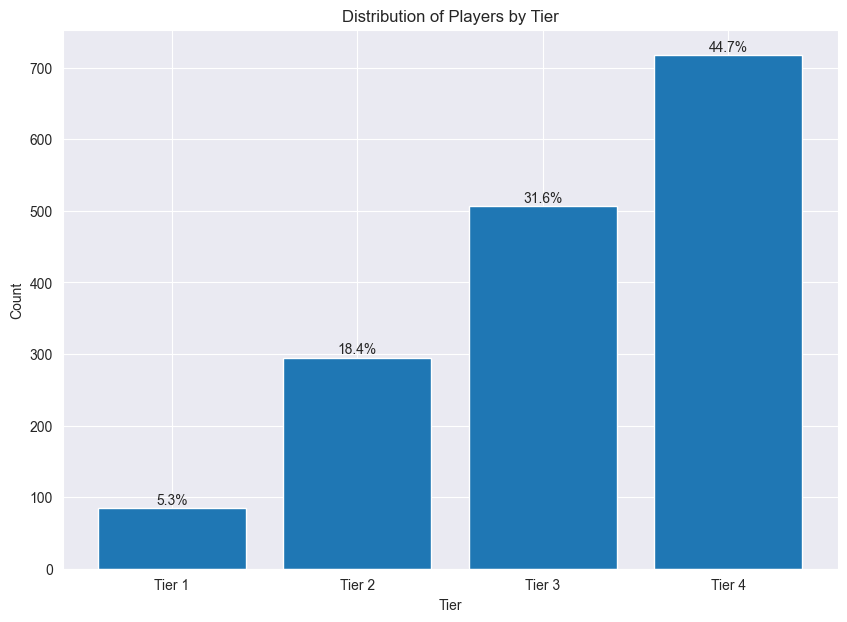

In [50]:
# Plot the distribution of players by tier
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_forwards['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_forwards) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [53]:
# Show Tier 1 Players
nhl_forwards[nhl_forwards['tier'] == 1]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,cluster,tier
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,1,0,0,0,2,1,0,1,3,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,1,1,0,0,2,0,0,1,3,1
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,0,1,0,1,0,0,0,1,1
28,56.0,Paul Kariya,15,15,989.0,11.0,82.0,402.0,587.0,989.0,...,0,0,2,0,0,0,0,1,1,1
29,58.0,Teemu Selanne,21,21,1451.0,12.0,84.0,684.0,773.0,1457.0,...,0,1,2,1,1,0,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,3521.0,Henrik Zetterberg,15,15,1082.0,45.0,82.0,337.0,623.0,960.0,...,0,0,1,0,1,1,0,0,3,1
1497,3532.0,Mike Modano,21,21,1499.0,30.0,82.0,561.0,813.0,1374.0,...,0,0,1,0,1,0,0,2,3,1
1501,3539.0,Daniel Alfredsson,18,18,1246.0,47.0,82.0,444.0,713.0,1157.0,...,0,1,1,0,0,0,0,1,3,1
1548,3691.0,Joe Pavelski,18,18,1332.0,46.0,82.0,476.0,592.0,1068.0,...,0,0,1,0,0,0,0,0,3,1


## Write to CSV

In [54]:
nhl_forwards.to_csv('../dataset/preprocess/nhl_forwards_with_tiers.csv', index=False, encoding='utf-8-sig')

In [55]:
# Find Connor Bedard
nhl_forwards[nhl_forwards['player_name_official'] == 'Connor Bedard']

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,cluster,tier
306,607.0,Connor Bedard,2,2,150.0,68.0,82.0,45.0,83.0,128.0,...,0,1,0,0,0,0,0,0,0,4
